In [57]:
#For what seems like ease of use, I am using Google Colab rather than GitHub CodeSpaces
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import timm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import (
    KFold,
    train_test_split,
    TimeSeriesSplit,
    StratifiedKFold,
    GroupKFold,
    StratifiedGroupKFold,
)
from sklearn.metrics import accuracy_score, roc_auc_score

In [58]:
#Using the kaggle package to downlod the dataset
import kagglehub
path = kagglehub.dataset_download("mdwaquarazam/agricultural-crops-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/mdwaquarazam/agricultural-crops-image-classification/versions/1


In [59]:
class PlantDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

In [60]:
dataset = PlantDataset(data_dir = '/root/.cache/kagglehub/datasets/mdwaquarazam/agricultural-crops-image-classification/versions/1/Agricultural-crops')

In [61]:
len(dataset)
dataset[9]

(<PIL.Image.Image image mode=RGB size=277x182>, 0)

In [65]:
data_dir = '/root/.cache/kagglehub/datasets/mdwaquarazam/agricultural-crops-image-classification/versions/1/Agricultural-crops'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'Cherry', 1: 'Coffee-plant', 2: 'Cucumber', 3: 'Fox_nut(Makhana)', 4: 'Lemon', 5: 'Olive-tree', 6: 'Pearl_millet(bajra)', 7: 'Tobacco-plant', 8: 'almond', 9: 'banana', 10: 'cardamom', 11: 'chilli', 12: 'clove', 13: 'coconut', 14: 'cotton', 15: 'gram', 16: 'jowar', 17: 'jute', 18: 'maize', 19: 'mustard-oil', 20: 'papaya', 21: 'pineapple', 22: 'rice', 23: 'soyabean', 24: 'sugarcane', 25: 'sunflower', 26: 'tea', 27: 'tomato', 28: 'vigna-radiati(Mung)', 29: 'wheat'}


In [66]:
#Turn the Images into Tensors of the same size
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

data_dir = '/root/.cache/kagglehub/datasets/mdwaquarazam/agricultural-crops-image-classification/versions/1/Agricultural-crops'
dataset = PlantDataset(data_dir, transform)

#Double checking the dimensions of the tensors
image, label = dataset[9]
image.shape

torch.Size([3, 128, 128])

In [67]:
#Need to set up cross validation before training
input_folder=data_dir
!pip install split-folders
import splitfolders
split_ratio = (0.7,0.2,0.1)
splitfolders.ratio( input_folder,
                  output='/content/sample_data', seed=9,
                  ratio=split_ratio,
                  group_prefix=None,
                  )

Copying files: 829 files [00:00, 2171.03 files/s]


In [68]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = '/content/sample_data/train'
test_folder = '/content/sample_data/test'
valid_folder = '/content/sample_data/val'

train_dataset = PlantDataset(train_folder, transform=transform)
test_dataset = PlantDataset(test_folder, transform=transform)
valid_dataset = PlantDataset(valid_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

target_to_class = {v: k for k, v in ImageFolder(train_folder).class_to_idx.items()}
print(target_to_class)

{0: 'Cherry', 1: 'Coffee-plant', 2: 'Cucumber', 3: 'Fox_nut(Makhana)', 4: 'Lemon', 5: 'Olive-tree', 6: 'Pearl_millet(bajra)', 7: 'Tobacco-plant', 8: 'almond', 9: 'banana', 10: 'cardamom', 11: 'chilli', 12: 'clove', 13: 'coconut', 14: 'cotton', 15: 'gram', 16: 'jowar', 17: 'jute', 18: 'maize', 19: 'mustard-oil', 20: 'papaya', 21: 'pineapple', 22: 'rice', 23: 'soyabean', 24: 'sugarcane', 25: 'sunflower', 26: 'tea', 27: 'tomato', 28: 'vigna-radiati(Mung)', 29: 'wheat'}


In [72]:
#creating the model
class PlantClassifier(nn.Module):
    def __init__(self, num_classes = 30):
      super(PlantClassifier, self).__init__()
      self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
      self.features = nn.Sequential(*list(self.base_model.children())[:-1])


      enet_out_size = 1280
      self.classifier = nn.Linear(enet_out_size, num_classes)


    def forward(self, x):
      x = self.features(x)
      output = self.classifier(x)
      return output

Model = PlantClassifier(num_classes=30)

In [73]:
example = Model(images)
example.shape

torch.Size([32, 30])

In [74]:
#Adding in the loss function and optimizer before testing it
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Model.parameters(), lr=0.001)

criterion(example, labels)

tensor(3.3968, grad_fn=<NllLossBackward0>)

In [82]:
#10 epochs took approx. 9 mins to train
num_epochs = 10
train_loss, val_loss = [], []
train_losses, val_losses = [], []

model = PlantClassifier(num_classes = 30)

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  for images, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * images.size(0)
  train_loss = running_loss / len(train_loader.dataset)
  train_losses.append(train_loss)

#Now we enter the validation phase
  model.eval()
  running_loss = 0.0
  with torch.no_grad():
    for images, labels in valid_loader:
      outputs = model(images)
      loss = criterion(outputs, labels)
      running_loss += loss.item() * images.size(0)
  val_loss = running_loss / len(valid_loader.dataset)
  val_losses.append(val_loss)
  print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

#Terrible losses. Look into what is wrong with the model

Epoch 1/10 - Train loss: 3.412318153833882, Validation loss: 3.386311204971806
Epoch 2/10 - Train loss: 3.416932843900523, Validation loss: 3.417890871724775
Epoch 3/10 - Train loss: 3.415436958805748, Validation loss: 3.431538627993676
Epoch 4/10 - Train loss: 3.4083678110622144, Validation loss: 3.4347618795210315
Epoch 5/10 - Train loss: 3.4131788314960123, Validation loss: 3.4355775048655848
Epoch 6/10 - Train loss: 3.4075814470884462, Validation loss: 3.436401347191103
Epoch 7/10 - Train loss: 3.412013425558858, Validation loss: 3.430381811818769
Epoch 8/10 - Train loss: 3.4057625479773606, Validation loss: 3.437271184305991
Epoch 9/10 - Train loss: 3.406132675432363, Validation loss: 3.436292326834894
Epoch 10/10 - Train loss: 3.4016327049275485, Validation loss: 3.4355512126799552


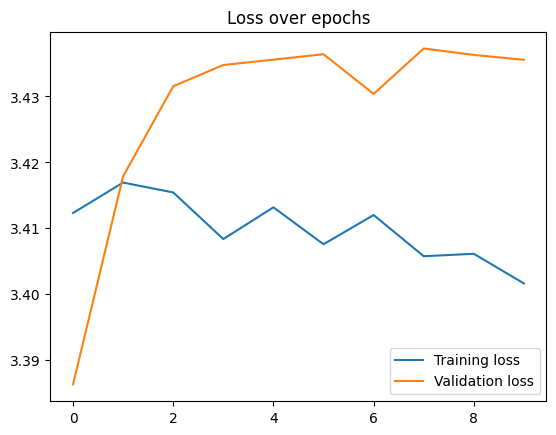

In [83]:
#Now we want to visualize the losses for better understanding
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()